Processing...
Done!


Dataset length: 50000
Metrics on 5000 graphs:
  MSE: 0.011164
  MAE: 0.069723
  MAPE: 19.74%


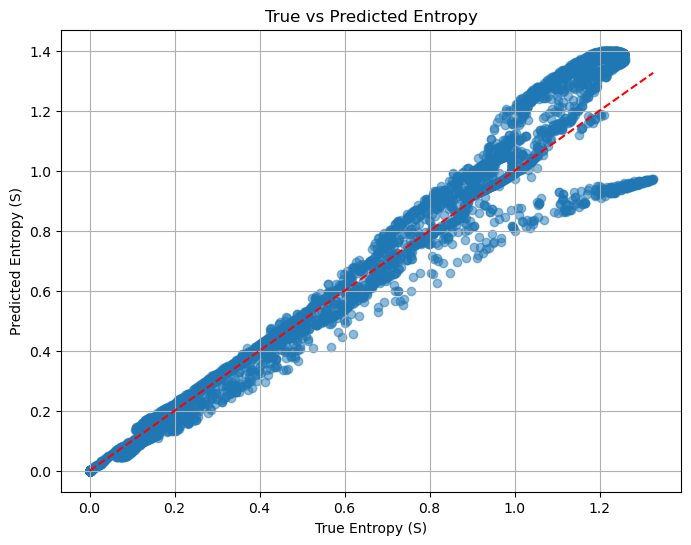

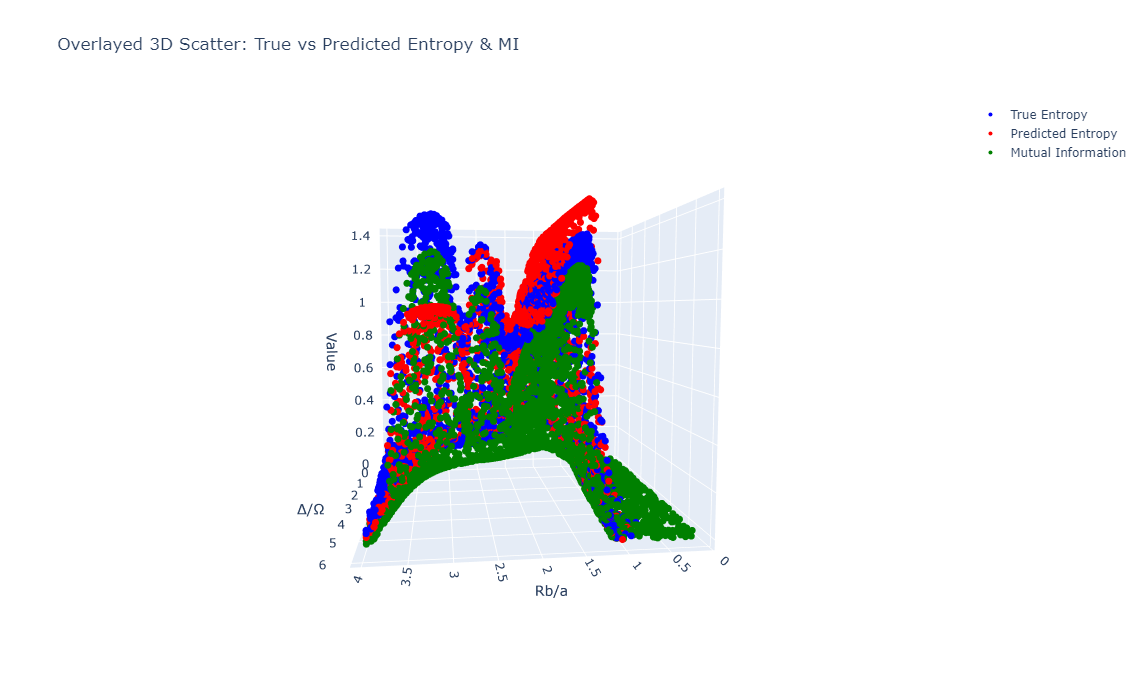

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals

# For interactive 3D plotting with Plotly
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Size12\processed_experimentaltest3\processed',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 1024,
    'num_layers': 8,
    'dropout_p': 0.4
}

# -----------------------------------------------------------------------------
# Dataset Class (Loads Preprocessed Data)
# -----------------------------------------------------------------------------
class SpinSystemDataset(InMemoryDataset):
    def __init__(self, root='.', transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        # Load preprocessed data saved previously
        processed_path = os.path.join(root, CONFIG['processed_file_name'])
        self.data, self.slices = torch.load(processed_path, map_location=torch.device('cpu'), weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [CONFIG['processed_file_name']]

    def download(self):
        pass

    def process(self):
        pass

def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])

# -----------------------------------------------------------------------------
# Model Definition (Now uses BatchNorm instead of LayerNorm)
# -----------------------------------------------------------------------------
class ExperimentalGNN(nn.Module):
    def __init__(self, hidden_channels=64, num_layers=6, dropout_p=0.4):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout_p = dropout_p

        # Define feature indices for slicing input features
        self.feature_indices = {
            'position': slice(0, 2),  # First two columns are position features
            'rydberg_val': 2,        # Third column is Rydberg value
            'mask': 3,                # Fourth column is mask
        }

        # Node and Edge Encoders
        self.node_encoder = nn.Sequential(
            nn.Linear(4, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU()
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(3, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU()
        )

        # Edge-Attention Layers
        self.edge_attention = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Linear(hidden_channels, 1),
                nn.Sigmoid()  # Attention weights between 0 and 1
            ) for _ in range(num_layers)
        ])

        # Edge-Node Co-Processing Layers
        self.convs = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(num_layers):
            if i % 2 == 0:
                # GINEConv with enhanced edge features
                mp_mlp = nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    BatchNorm(hidden_channels),
                    nn.SiLU(),
                    nn.Dropout(dropout_p),
                    nn.Linear(hidden_channels, hidden_channels)
                )
                conv = GINEConv(mp_mlp, edge_dim=hidden_channels)
            else:
                # TransformerConv with edge-aware attention
                conv = TransformerConv(
                    hidden_channels,
                    hidden_channels // 8,
                    heads=8,
                    edge_dim=hidden_channels,
                    dropout=dropout_p,
                    beta=True,
                    concat=True
                )
            self.convs.append(conv)

            # Edge MLP with BatchNorm
            self.edge_convs.append(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ))

            # Node features BN after convolution
            self.norms.append(BatchNorm(hidden_channels))

        # Edge-Preserving Pooling
        self.pool = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ) for _ in range(num_layers // 2)
        ])

        # Readout with Edge Information
        self.readout = nn.ModuleList([
            Set2Set(hidden_channels, processing_steps=4) for _ in range(2)  # 2 heads
        ])
        
        # Dimension reduction for readout outputs
        self.readout_projection = nn.Sequential(
            nn.Linear(4 * hidden_channels, 2 * hidden_channels),  # 4 = 2 heads * 2 (Set2Set doubles dim)
            BatchNorm(2 * hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p)
        )

        # Global Features MLP
        self.global_mlp = nn.Sequential(
            nn.Linear(2, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels)
        )

        # Final MLP with corrected dimensions
        combined_dim = (2 * hidden_channels) + hidden_channels  # projected readout + global features
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels // 2),
            BatchNorm(hidden_channels // 2),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Node and Edge Feature Encoding
        node_features = torch.cat([
            x[:, self.feature_indices['position']],
            x[:, self.feature_indices['rydberg_val']].unsqueeze(-1),
            x[:, self.feature_indices['mask']].unsqueeze(-1),
        ], dim=1)

        edge_features = edge_attr

        x_enc = self.node_encoder(node_features)
        e_enc = self.edge_encoder(edge_features)

        # Message Passing with Edge-Attention
        h = x_enc
        for i in range(self.num_layers):
            # Compute edge attention weights
            edge_weights = self.edge_attention[i](e_enc).squeeze(-1)

            # Update edge features
            e_enc = self.edge_convs[i](e_enc)

            # Perform convolution with edge attention
            h_new = self.convs[i](h, edge_index, e_enc * edge_weights.unsqueeze(-1))

            # BatchNorm on node outputs
            h_new = self.norms[i](h_new)

            # Residual connection
            h = h + h_new

            # Edge-Preserving Pooling
            if i % 2 == 0 and i // 2 < len(self.pool):
                h = self.pool[i // 2](h)

        # Multi-Head Readout with dimension reduction
        readouts = [rd(h, batch) for rd in self.readout]
        h_readout = torch.cat(readouts, dim=1)
        h_readout = self.readout_projection(h_readout)

        # Global Features
        nA_over_N = data.nA.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        nB_over_N = data.nB.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        global_feats = torch.stack([nA_over_N, nB_over_N], dim=1)
        gf_out = self.global_mlp(global_feats)

        # Combine features with correct dimensions
        combined = torch.cat([h_readout, gf_out], dim=1)
        out = self.final_mlp(combined).squeeze(-1)
        return out

# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # Model output is predicted S/N; retrieve system_size and convert to absolute S:
            pred = model(data)   # predicted S/N
            system_size = data.system_size.squeeze(-1)
            pred_S = pred * system_size
            
            targets = data.y.squeeze()  # Raw S
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred_S.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_3d_overlay_interactive(rb_over_a, delta_over_omega, targets, preds, mutual_info,
                                save_html=False, html_filename='3d_overlay.html'):
    """
    Create an interactive 3D scatter plot overlaying the three series.
    Use save_html=True to save the plot as an HTML file.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=rb_over_a, y=delta_over_omega, z=targets,
        mode='markers',
        marker=dict(size=4, color='blue'),
        name='True Entropy'
    ))
    fig.add_trace(go.Scatter3d(
        x=rb_over_a, y=delta_over_omega, z=preds,
        mode='markers',
        marker=dict(size=4, color='red'),
        name='Predicted Entropy'
    ))
    fig.add_trace(go.Scatter3d(
        x=rb_over_a, y=delta_over_omega, z=mutual_info,
        mode='markers',
        marker=dict(size=4, color='green'),
        name='Mutual Information'
    ))
    fig.update_layout(
        width=900,
        height=700,
        scene=dict(
            xaxis_title='Rb/a',
            yaxis_title='Δ/Ω',
            zaxis_title='Value'
        ),
        title="Overlayed 3D Scatter: True vs Predicted Entropy & MI"
    )
    if save_html:
        fig.write_html(html_filename)
        print(f"Interactive plot saved as {html_filename}")
    else:
        fig.show()

# -----------------------------------------------------------------------------
# Main Function
# -----------------------------------------------------------------------------
def main():

    model_path = 'best_model_rung1_6_scaled.pth'
    N = 5000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    

    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    plot_results(preds, targets)

    plot_3d_overlay_interactive(rb_over_a, delta_over_omega, targets, preds, mutual_info, save_html=False)

if __name__ == "__main__":
    main()


Processing...
Done!


Dataset length: 5000
Metrics on 5000 graphs:
  MSE: 0.019368
  MAE: 0.128129
  MAPE: 11.64%


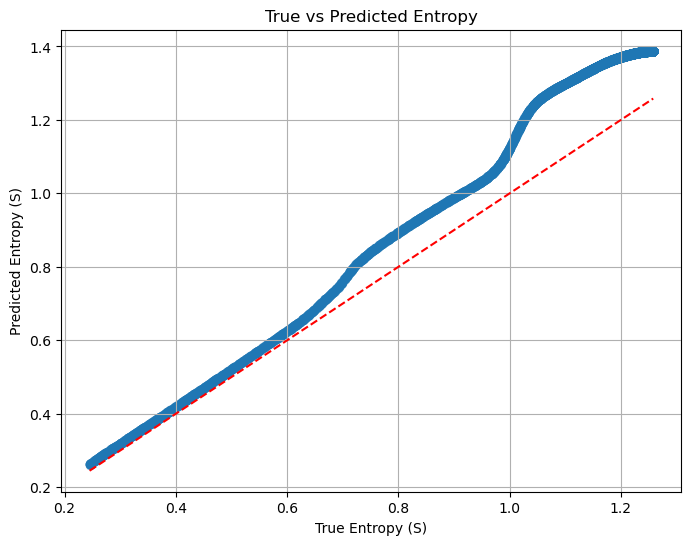

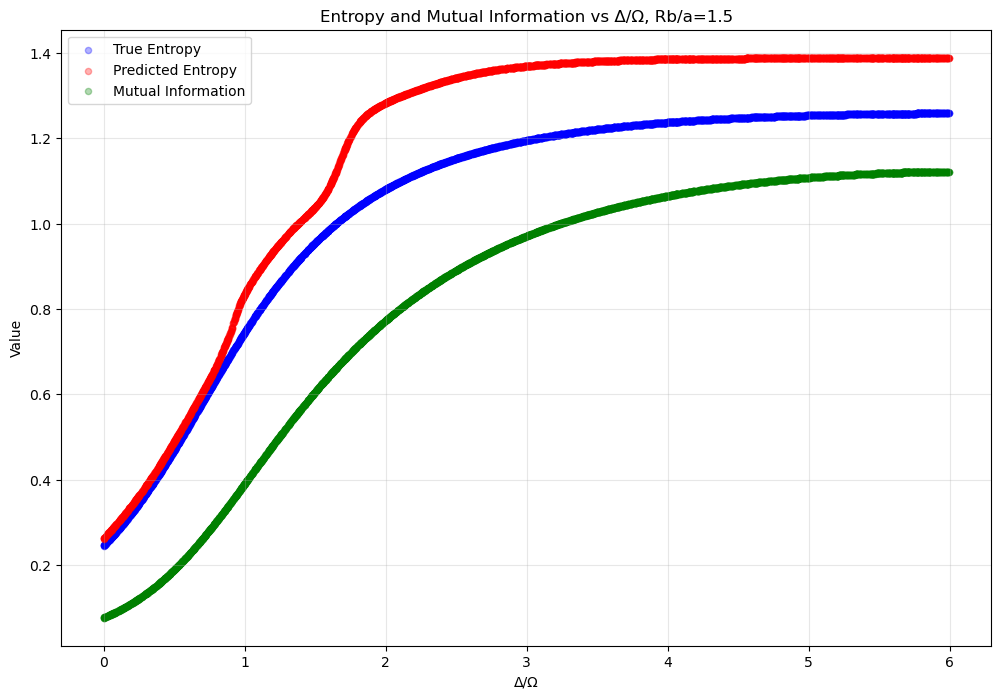

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals

# For interactive 3D plotting with Plotly
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Size12nonorm\processed_experimentaltest\processed',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 512,
    'num_layers': 8,
    'dropout_p': 0.4
}

# -----------------------------------------------------------------------------
# Dataset Class (Loads Preprocessed Data)
# -----------------------------------------------------------------------------
class SpinSystemDataset(InMemoryDataset):
    def __init__(self, root='.', transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        # Load preprocessed data saved previously
        processed_path = os.path.join(root, CONFIG['processed_file_name'])
        self.data, self.slices = torch.load(processed_path, map_location=torch.device('cpu'), weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [CONFIG['processed_file_name']]

    def download(self):
        pass

    def process(self):
        pass

def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])

# -----------------------------------------------------------------------------
# Model Definition (Now uses BatchNorm instead of LayerNorm)
# -----------------------------------------------------------------------------
class ExperimentalGNN(nn.Module):
    def __init__(self, hidden_channels=64, num_layers=6, dropout_p=0.4):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout_p = dropout_p

        # Define feature indices for slicing input features
        self.feature_indices = {
            'position': slice(0, 2),  # First two columns are position features
            'rydberg_val': 2,        # Third column is Rydberg value
            'mask': 3,               # Fourth column is mask
        }

        # Node and Edge Encoders
        self.node_encoder = nn.Sequential(
            nn.Linear(4, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU()
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(3, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU()
        )

        # Edge-Attention Layers
        self.edge_attention = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Linear(hidden_channels, 1),
                nn.Sigmoid()  # Attention weights between 0 and 1
            ) for _ in range(num_layers)
        ])

        # Edge-Node Co-Processing Layers
        self.convs = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(num_layers):
            if i % 2 == 0:
                # GINEConv with enhanced edge features
                mp_mlp = nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    BatchNorm(hidden_channels),
                    nn.SiLU(),
                    nn.Dropout(dropout_p),
                    nn.Linear(hidden_channels, hidden_channels)
                )
                conv = GINEConv(mp_mlp, edge_dim=hidden_channels)
            else:
                # TransformerConv with edge-aware attention
                conv = TransformerConv(
                    hidden_channels,
                    hidden_channels // 8,
                    heads=8,
                    edge_dim=hidden_channels,
                    dropout=dropout_p,
                    beta=True,
                    concat=True
                )
            self.convs.append(conv)

            # Edge MLP with BatchNorm
            self.edge_convs.append(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ))

            # Node features BN after convolution
            self.norms.append(BatchNorm(hidden_channels))

        # Edge-Preserving Pooling
        self.pool = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ) for _ in range(num_layers // 2)
        ])

        # Readout with Edge Information
        self.readout = nn.ModuleList([
            Set2Set(hidden_channels, processing_steps=4) for _ in range(2)  # 2 heads
        ])
        
        # Dimension reduction for readout outputs
        self.readout_projection = nn.Sequential(
            nn.Linear(4 * hidden_channels, 2 * hidden_channels),  # 4 = 2 heads * 2 (Set2Set doubles dim)
            BatchNorm(2 * hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p)
        )

        # Global Features MLP
        self.global_mlp = nn.Sequential(
            nn.Linear(2, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels)
        )

        # Final MLP with corrected dimensions
        combined_dim = (2 * hidden_channels) + hidden_channels  # projected readout + global features
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels // 2),
            BatchNorm(hidden_channels // 2),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Node and Edge Feature Encoding
        node_features = torch.cat([
            x[:, self.feature_indices['position']],
            x[:, self.feature_indices['rydberg_val']].unsqueeze(-1),
            x[:, self.feature_indices['mask']].unsqueeze(-1),
        ], dim=1)

        edge_features = edge_attr

        x_enc = self.node_encoder(node_features)
        e_enc = self.edge_encoder(edge_features)

        # Message Passing with Edge-Attention
        h = x_enc
        for i in range(self.num_layers):
            # Compute edge attention weights
            edge_weights = self.edge_attention[i](e_enc).squeeze(-1)

            # Update edge features
            e_enc = self.edge_convs[i](e_enc)

            # Perform convolution with edge attention
            h_new = self.convs[i](h, edge_index, e_enc * edge_weights.unsqueeze(-1))

            # BatchNorm on node outputs
            h_new = self.norms[i](h_new)

            # Residual connection
            h = h + h_new

            # Edge-Preserving Pooling
            if i % 2 == 0 and i // 2 < len(self.pool):
                h = self.pool[i // 2](h)

        # Multi-Head Readout with dimension reduction
        readouts = [rd(h, batch) for rd in self.readout]
        h_readout = torch.cat(readouts, dim=1)
        h_readout = self.readout_projection(h_readout)

        # Global Features
        nA_over_N = data.nA.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        nB_over_N = data.nB.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        global_feats = torch.stack([nA_over_N, nB_over_N], dim=1)
        gf_out = self.global_mlp(global_feats)

        # Combine features with correct dimensions
        combined = torch.cat([h_readout, gf_out], dim=1)
        out = self.final_mlp(combined).squeeze(-1)
        return out

# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # Model output is predicted S/N; retrieve system_size and convert to absolute S:
            pred = model(data)   # predicted S/N
            system_size = data.system_size.squeeze(-1)
            pred_S = pred * system_size
            
            targets = data.y.squeeze()  # Raw S
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred_S.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_2d_values_vs_delta_omega(delta_over_omega, targets, preds, mutual_info, 
                                  save_fig=False, fig_filename='2d_plot.png'):
    """
    Create a 2D plot showing true entropy, predicted entropy, and mutual information
    against delta/omega values.
    """
    plt.figure(figsize=(12, 8))
    
    # Sort all arrays by delta_over_omega for better visualization
    sort_idx = np.argsort(delta_over_omega)
    delta_over_omega = delta_over_omega[sort_idx]
    targets = targets[sort_idx]
    preds = preds[sort_idx]
    mutual_info = mutual_info[sort_idx]
    
    plt.scatter(delta_over_omega, targets, alpha=0.3, label='True Entropy', color='blue', s=20)
    plt.scatter(delta_over_omega, preds, alpha=0.3, label='Predicted Entropy', color='red', s=20)
    plt.scatter(delta_over_omega, mutual_info, alpha=0.3, label='Mutual Information', color='green', s=20)
    
    plt.xlabel('Δ/Ω')
    plt.ylabel('Value')
    plt.title('Entropy and Mutual Information vs Δ/Ω, Rb/a=1.5')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def main():
    # Point to the model you trained with BatchNorm
    model_path = 'best_model_rung1_6_scaled.pth'
    N = 5000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    # Load the trained model (which includes BN statistics)
    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    # Create both plots
    plot_results(preds, targets)
    plot_2d_values_vs_delta_omega(delta_over_omega, targets, preds, mutual_info, save_fig=False)

if __name__ == "__main__":
    main()


Building Hamiltonian...
Dimension of Hilbert: 2^16 = 65536
Ground-state energy: -30.046969
Exact Von Neumann Entropy (subsystem A): 0.720389
Exact Classical MI: 0.397642
GNN-predicted VNE (no cutoff): 0.000000


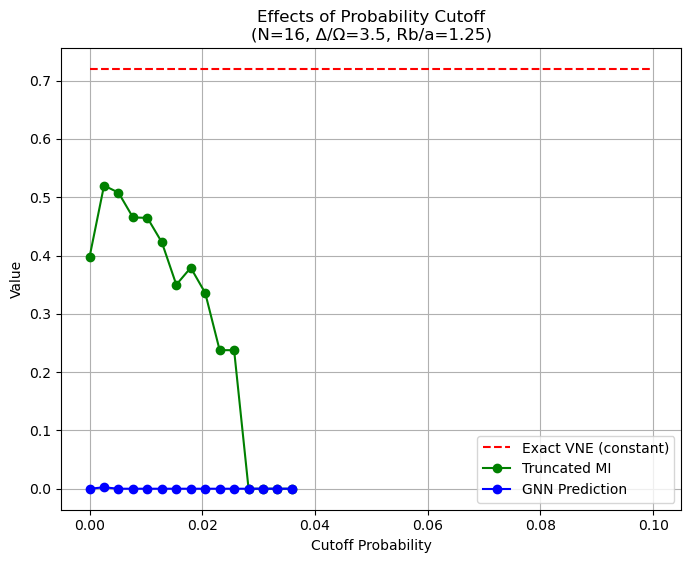

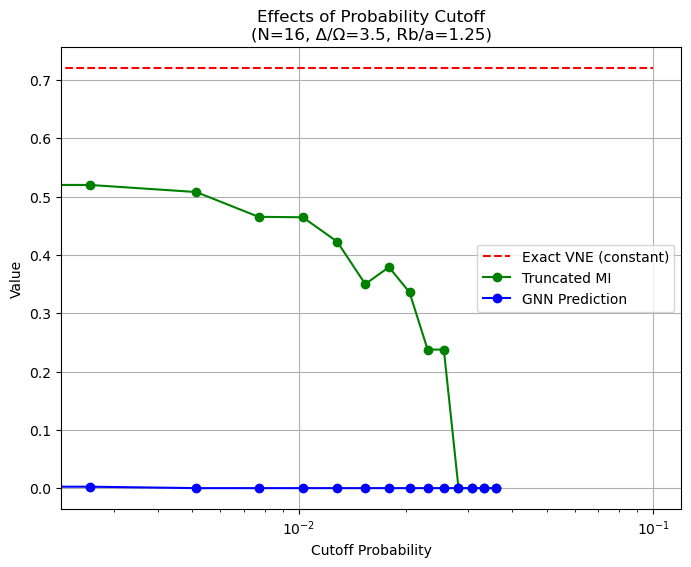

In [60]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import netket as nk
from netket.operator.spin import sigmax, sigmaz, sigmam, sigmap

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch.serialization import safe_globals

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)

# ---------------------------------------------------------------------
# GNN Model (ensure same hyperparams as your "best_model.pth")
# ---------------------------------------------------------------------
class ExperimentalGNN(nn.Module):
    def __init__(self, hidden_channels=64, num_layers=6, dropout_p=0.4):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout_p = dropout_p

        # Define feature indices for slicing input features
        self.feature_indices = {
            'position': slice(0, 2),  # First two columns are position features
            'rydberg_val': 2,        # Third column is Rydberg value
            'mask': 3,                # Fourth column is mask
        }

        # Node and Edge Encoders
        self.node_encoder = nn.Sequential(
            nn.Linear(4, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU()
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(3, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU()
        )

        # Edge-Attention Layers
        self.edge_attention = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Linear(hidden_channels, 1),
                nn.Sigmoid()  # Attention weights between 0 and 1
            ) for _ in range(num_layers)
        ])

        # Edge-Node Co-Processing Layers
        self.convs = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(num_layers):
            if i % 2 == 0:
                # GINEConv with enhanced edge features
                mp_mlp = nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    BatchNorm(hidden_channels),
                    nn.SiLU(),
                    nn.Dropout(dropout_p),
                    nn.Linear(hidden_channels, hidden_channels)
                )
                conv = GINEConv(mp_mlp, edge_dim=hidden_channels)
            else:
                # TransformerConv with edge-aware attention
                conv = TransformerConv(
                    hidden_channels,
                    hidden_channels // 8,
                    heads=8,
                    edge_dim=hidden_channels,
                    dropout=dropout_p,
                    beta=True,
                    concat=True
                )
            self.convs.append(conv)

            # Edge MLP with BatchNorm
            self.edge_convs.append(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ))

            # Node features BN after convolution
            self.norms.append(BatchNorm(hidden_channels))

        # Edge-Preserving Pooling
        self.pool = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                BatchNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ) for _ in range(num_layers // 2)
        ])

        # Readout with Edge Information
        self.readout = nn.ModuleList([
            Set2Set(hidden_channels, processing_steps=4) for _ in range(2)  # 2 heads
        ])
        
        # Dimension reduction for readout outputs
        self.readout_projection = nn.Sequential(
            nn.Linear(4 * hidden_channels, 2 * hidden_channels),  # 4 = 2 heads * 2 (Set2Set doubles dim)
            BatchNorm(2 * hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p)
        )

        # Global Features MLP
        self.global_mlp = nn.Sequential(
            nn.Linear(2, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels)
        )

        # Final MLP with corrected dimensions
        combined_dim = (2 * hidden_channels) + hidden_channels  # projected readout + global features
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_channels),
            BatchNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels // 2),
            BatchNorm(hidden_channels // 2),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Node and Edge Feature Encoding
        node_features = torch.cat([
            x[:, self.feature_indices['position']],
            x[:, self.feature_indices['rydberg_val']].unsqueeze(-1),
            x[:, self.feature_indices['mask']].unsqueeze(-1),
        ], dim=1)

        edge_features = edge_attr

        x_enc = self.node_encoder(node_features)
        e_enc = self.edge_encoder(edge_features)

        # Message Passing with Edge-Attention
        h = x_enc
        for i in range(self.num_layers):
            # Compute edge attention weights
            edge_weights = self.edge_attention[i](e_enc).squeeze(-1)

            # Update edge features
            e_enc = self.edge_convs[i](e_enc)

            # Perform convolution with edge attention
            h_new = self.convs[i](h, edge_index, e_enc * edge_weights.unsqueeze(-1))

            # BatchNorm on node outputs
            h_new = self.norms[i](h_new)

            # Residual connection
            h = h + h_new

            # Edge-Preserving Pooling
            if i % 2 == 0 and i // 2 < len(self.pool):
                h = self.pool[i // 2](h)

        # Multi-Head Readout with dimension reduction
        readouts = [rd(h, batch) for rd in self.readout]
        h_readout = torch.cat(readouts, dim=1)
        h_readout = self.readout_projection(h_readout)

        # Global Features
        nA_over_N = data.nA.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        nB_over_N = data.nB.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        global_feats = torch.stack([nA_over_N, nB_over_N], dim=1)
        gf_out = self.global_mlp(global_feats)

        # Combine features with correct dimensions
        combined = torch.cat([h_readout, gf_out], dim=1)
        out = self.final_mlp(combined).squeeze(-1)
        return out

# ---------------------------------------------------------------------
# Helper functions for exact calculations
# ---------------------------------------------------------------------
def get_symmetric_partition_indices(Nx, Ny):
    N = Nx * Ny
    sites = [(x, y) for x in range(Nx) for y in range(Ny)]
    mid_y = Ny / 2
    A_indices = [i for i, (xx, yy) in enumerate(sites) if yy < mid_y]
    return sorted(A_indices)

def reshape_for_subsystem(psi, A_indices, N):
    A_set = set(A_indices)
    B_indices = [i for i in range(N) if i not in A_set]
    A_map = {spin: pos for pos, spin in enumerate(A_indices)}
    B_map = {spin: pos for pos, spin in enumerate(B_indices)}

    N_A = len(A_indices)
    N_B = N - N_A
    psi_reshaped = np.zeros((2**N_A, 2**N_B), dtype=psi.dtype)

    for global_idx in range(2**N):
        tmp = global_idx
        i_A = 0
        i_B = 0
        for spin in range(N):
            bit = (tmp & 1)
            tmp >>= 1
            if spin in A_map:
                i_A |= (bit << A_map[spin])
            else:
                i_B |= (bit << B_map[spin])
        psi_reshaped[i_A, i_B] = psi[global_idx]

    return psi_reshaped

def calculate_von_neumann_entropy(psi, A_indices, N):
    psi_2D = reshape_for_subsystem(psi, A_indices, N)
    U, s, Vh = np.linalg.svd(psi_2D, full_matrices=False)
    s2 = s**2
    s2 /= s2.sum() + 1e-14
    vne = -np.sum(s2 * np.log(s2 + 1e-14))
    return vne

def calculate_classical_MI(psi, A_indices, N):
    B_indices = [i for i in range(N) if i not in A_indices]
    probabilities = np.abs(psi)**2
    
    p_A = np.zeros(2**len(A_indices))
    p_B = np.zeros(2**len(B_indices))

    for global_idx in range(2**N):
        prob = probabilities[global_idx]
        if prob < 1e-14:
            continue
        bin_str = format(global_idx, f"0{N}b")
        A_part = ''.join(bin_str[i] for i in A_indices)
        B_part = ''.join(bin_str[i] for i in B_indices)
        A_state = int(A_part, 2)
        B_state = int(B_part, 2)
        p_A[A_state] += prob
        p_B[B_state] += prob

    MI = 0.0
    for global_idx in range(2**N):
        prob = probabilities[global_idx]
        if prob < 1e-14:
            continue
        bin_str = format(global_idx, f"0{N}b")
        A_part = ''.join(bin_str[i] for i in A_indices)
        B_part = ''.join(bin_str[i] for i in B_indices)
        A_state = int(A_part, 2)
        B_state = int(B_part, 2)
        MI += prob * np.log(prob / (p_A[A_state] * p_B[B_state] + 1e-14) + 1e-14)
    return float(MI)

# ---------------------------------------------------------------------
# Minimal wavefunction -> PyG Data logic
# ---------------------------------------------------------------------
def calculate_quantum_correlations_optimized(state_indices, state_probs, N):
    from itertools import combinations
    correlations = np.zeros((N, N), dtype=np.float32)
    states = np.array(state_indices, dtype=np.int64)
    probs = np.array(state_probs, dtype=np.float32)

    for i in range(N):
        mask = (states & (1 << i)) != 0
        correlations[i, i] = np.sum(probs[mask])

    for i, j in combinations(range(N), 2):
        mask = ((states & (1 << i)) != 0) & ((states & (1 << j)) != 0)
        corr = np.sum(probs[mask])
        connected_corr = corr - correlations[i, i]*correlations[j, j]
        correlations[i, j] = connected_corr
        correlations[j, i] = connected_corr
    return correlations

def create_edges_with_cutoff(positions, N, distance_cutoff=6):
    edges = []
    for i in range(N):
        for j in range(i + 1, N):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= distance_cutoff:
                edges.append([i, j])
    if edges:
        return np.array(edges, dtype=np.int64).T
    return np.zeros((2,0), dtype=np.int64)

def process_single_row(row_data):
    Nx = 2
    Ny = row_data['Ny']
    N = Nx * Ny
    distance_cutoff = 6.0
    
    positions = np.array([(col, row * 2) for row in range(Nx) for col in range(Ny)], dtype=np.float32)
    correlation_matrix = calculate_quantum_correlations_optimized(
        row_data['All_Indices'], row_data['All_Probabilities'], N
    )

    mask_str = row_data['Subsystem_Mask']
    mask = np.array([int(ch) for ch in mask_str], dtype=np.float32).reshape(-1, 1)

    node_features = np.concatenate([
        positions,
        correlation_matrix.diagonal().reshape(-1, 1),
        mask
    ], axis=1)

    edge_index = create_edges_with_cutoff(positions, N, distance_cutoff)
    if edge_index.size > 0:
        pos_i = positions[edge_index[0]]
        pos_j = positions[edge_index[1]]
        vec_ij = pos_j - pos_i
        dist_ij = np.linalg.norm(vec_ij, axis=1, keepdims=True) / np.sqrt(N)
        angle_ij = np.arctan2(vec_ij[:,1], vec_ij[:,0]).reshape(-1, 1)
        corr_values = correlation_matrix[edge_index[0], edge_index[1]].reshape(-1, 1)
        edge_attr = np.concatenate([angle_ij, corr_values, dist_ij], axis=1)
    else:
        edge_attr = np.zeros((0,3), dtype=np.float32)

    data_obj = Data(
        x=torch.tensor(node_features, dtype=torch.float32),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float32),
        y=torch.tensor([row_data['Von_Neumann_Entropy']], dtype=torch.float32),
        MI=torch.tensor([row_data['Classical_MI']], dtype=torch.float32),
        delta_over_omega=torch.tensor([row_data['Delta_over_Omega']], dtype=torch.float32),
        rb_over_a=torch.tensor([row_data['Rb_over_a']], dtype=torch.float32),
        system_size=torch.tensor([[N]], dtype=torch.float32),
        nA=torch.tensor([[mask.sum()]], dtype=torch.float32),
        nB=torch.tensor([[N - mask.sum()]], dtype=torch.float32),
    )
    return data_obj

# ---------------------------------------------------------------------
# Build Hamiltonian with the "1/4" factor in the Rydberg Interaction
# ---------------------------------------------------------------------
def build_rydberg_hamiltonian(Nx, Ny, Delta_over_Omega, Rb_over_a, R_cut=6.0):
    """
    Matches your snippet:  V_ij = (Rb_over_a^6)/(4 * r^6).
    """
    N = Nx * Ny
    positions = []
    for row in range(Nx):
        for col in range(Ny):
            positions.append((col, row * 2))  # same geometry as your code
    positions = np.array(positions, dtype=float)

    hi = nk.hilbert.Spin(s=1/2, N=N)
    sigmap_ops = [sigmap(hi, i) for i in range(N)]
    sigmam_ops = [sigmam(hi, i) for i in range(N)]
    sigmaz_ops = [sigmaz(hi, i) for i in range(N)]

    H = nk.operator.LocalOperator(hi)

    # Onsite terms
    for i in range(N):
        # (1/2)*(σ^+ + σ^-)
        H += 0.5 * (sigmap_ops[i] + sigmam_ops[i])
        # (Delta_over_Omega/2)*(σz - 1)
        H += (Delta_over_Omega/2) * (sigmaz_ops[i] - 1)

    # Interaction terms
    for i in range(N):
        for j in range(i+1, N):
            dx = positions[i,0] - positions[j,0]
            dy = positions[i,1] - positions[j,1]
            r = np.sqrt(dx*dx + dy*dy)
            if r <= R_cut:
                # Factor 1/4 in the denominator (plus r^6):
                V_ij = Rb_over_a**6 / (4.0 * (r**6 + 1e-14))
                H += V_ij * (sigmaz_ops[i] - 1) * (sigmaz_ops[j] - 1)

    sp_h = H.to_sparse()
    sp_h_csr = csr_matrix(sp_h)
    return sp_h_csr

def load_trained_gnn(model_path):
    model = ExperimentalGNN(hidden_channels=512, num_layers=6, dropout_p=0.4)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model

def main():
    # ------------------
    # Single parameters
    # ------------------
    Nx = 2
    Ny = 8
    Delta_over_Omega = 3.5
    Rb_over_a = 1.25
    R_cut = 6.0

    print("Building Hamiltonian...")
    H_csr = build_rydberg_hamiltonian(Nx, Ny, Delta_over_Omega, Rb_over_a, R_cut)
    N = Nx * Ny
    print(f"Dimension of Hilbert: 2^{N} = {2**N}")


    vals, vecs = eigsh(H_csr, k=1, which='SA')
    E_gs = vals[0]
    psi_gs = vecs[:,0]
    psi_gs /= np.linalg.norm(psi_gs)

    print(f"Ground-state energy: {E_gs:.6f}")

    A_indices = get_symmetric_partition_indices(Nx, Ny)
    vne_exact = calculate_von_neumann_entropy(psi_gs, A_indices, N)
    MI_exact = calculate_classical_MI(psi_gs, A_indices, N)
    print(f"Exact Von Neumann Entropy (subsystem A): {vne_exact:.6f}")
    print(f"Exact Classical MI: {MI_exact:.6f}")

    # Build Data object
    probabilities = np.abs(psi_gs)**2
    indices = np.arange(len(probabilities))
    mask = np.zeros(N, dtype=int)
    for idx in A_indices:
        mask[idx] = 1
    mask_str = ''.join(str(x) for x in mask)

    row_data_full = {
        'Ny': Ny,
        'Delta_over_Omega': Delta_over_Omega,
        'Rb_over_a': Rb_over_a,
        'Energy': E_gs,
        'All_Indices': indices.tolist(),
        'All_Probabilities': probabilities.tolist(),
        'Von_Neumann_Entropy': vne_exact,
        'Classical_MI': MI_exact,
        'Subsystem_Mask': mask_str
    }
    data_full = process_single_row(row_data_full)
    batch_full = Batch.from_data_list([data_full])

    # Load GNN
    model_path = "best_model_rung1_6_scaled.pth"
    model = load_trained_gnn(model_path)
    with torch.no_grad():
        pred_vne_full = model(batch_full)*Ny*Nx
    print(f"GNN-predicted VNE (no cutoff): {float(pred_vne_full):.6f}")

    # Probability cutoffs
    cutoffs = np.linspace(0.0, 0.1, 40)
    classical_MIs = []
    gnn_preds = []

    for cval in cutoffs:
        keep_mask = (probabilities >= cval)
        if not np.any(keep_mask):
            classical_MIs.append(np.nan)
            gnn_preds.append(np.nan)
            continue
        truncated_probs = probabilities[keep_mask].copy()
        truncated_probs /= truncated_probs.sum() + 1e-14
        truncated_psi = np.sqrt(truncated_probs)

        truncated_indices = indices[keep_mask]
        psi_trunc_full = np.zeros_like(probabilities)
        psi_trunc_full[truncated_indices] = truncated_psi

        cur_MI = calculate_classical_MI(psi_trunc_full, A_indices, N)

        row_data_cut = {
            'Ny': Ny,
            'Delta_over_Omega': Delta_over_Omega,
            'Rb_over_a': Rb_over_a,
            'Energy': E_gs,
            'All_Indices': truncated_indices.tolist(),
            'All_Probabilities': truncated_probs.tolist(),
            'Von_Neumann_Entropy': vne_exact,  # "real" wavefunction's VNE is unchanged
            'Classical_MI': cur_MI,
            'Subsystem_Mask': mask_str
        }
        data_cut = process_single_row(row_data_cut)
        batch_cut = Batch.from_data_list([data_cut])
        with torch.no_grad():
            pred_vne_cut = model(batch_cut)*Ny*Nx
        classical_MIs.append(cur_MI)
        gnn_preds.append(float(pred_vne_cut))

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(cutoffs, [vne_exact]*len(cutoffs), 'r--', label='Exact VNE (constant)')
    plt.plot(cutoffs, classical_MIs, 'g-o', label='Truncated MI')
    plt.plot(cutoffs, gnn_preds, 'b-o', label='GNN Prediction')
    plt.xlabel("Cutoff Probability")
    plt.ylabel("Value")
    plt.title(f"Effects of Probability Cutoff\n(N={N}, Δ/Ω={Delta_over_Omega}, Rb/a={Rb_over_a})")
    plt.grid(True)
    plt.legend()
    plt.show()


    plt.figure(figsize=(8,6))
    plt.plot(cutoffs, [vne_exact]*len(cutoffs), 'r--', label='Exact VNE (constant)')
    plt.plot(cutoffs, classical_MIs, 'g-o', label='Truncated MI')
    plt.plot(cutoffs, gnn_preds, 'b-o', label='GNN Prediction')
    plt.xlabel("Cutoff Probability")
    plt.ylabel("Value")
    plt.title(f"Effects of Probability Cutoff\n(N={N}, Δ/Ω={Delta_over_Omega}, Rb/a={Rb_over_a})")
    plt.grid(True)
    plt.xscale('log')
    plt.legend()
    plt.show()
if __name__ == "__main__":
    main()
